<a href="https://colab.research.google.com/github/CameronLarsonFLT/PyTorch_FP_Prediction/blob/main/PyTorch_FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/CameronLarsonFLT/PyTorch_FP_Prediction/main/FPs.png" width="450" align="right">

##PyTorch FP Property Predictor

> **Example script** demonstrating how to:
- Retrieve fluorescent protein (FP) data from the **FPbase API**
- Train a simple **PyTorch neural network**
- Predict key **spectral / photophysical properties** from an **amino-acid sequence**

**Inputs:** `protein sequence (AA)`  
**Outputs:** `ex_max`, `em_max`, `brightness`, `pKa`, `stokes_shift`

Predicting property: brightness
Device: cuda
Fetching https://www.fpbase.org/api/proteins/?parent_organism=6100&format=json …
Proteins after cleanup: 286
No Valine remains at position 2
Usable samples: 148
Max sequence length in dataset: 353


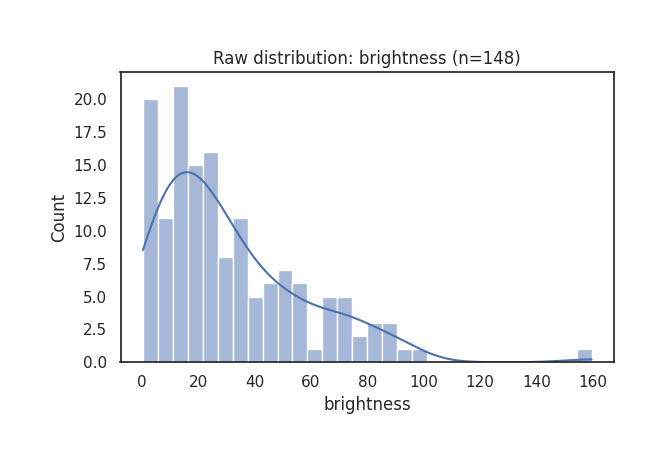

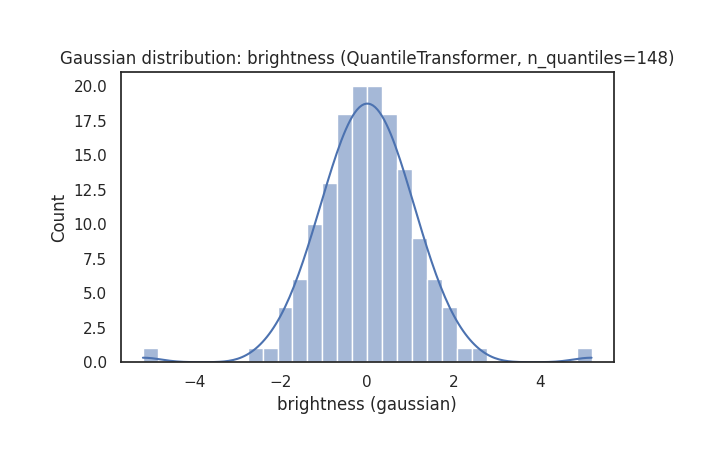

Target transform: GAUSSIANIZED
Raw y:    mean=31.456  std=26.238
Gauss y:  mean=0.000  std=1.138
Using minibatches: batch_size=32 | steps/epoch=5


Training:   0%|          | 0/2000 [ETA ?] 

FP_Seq predicted brightness (gaussian): 0.087
FP_Seq predicted brightness (original): 26.074


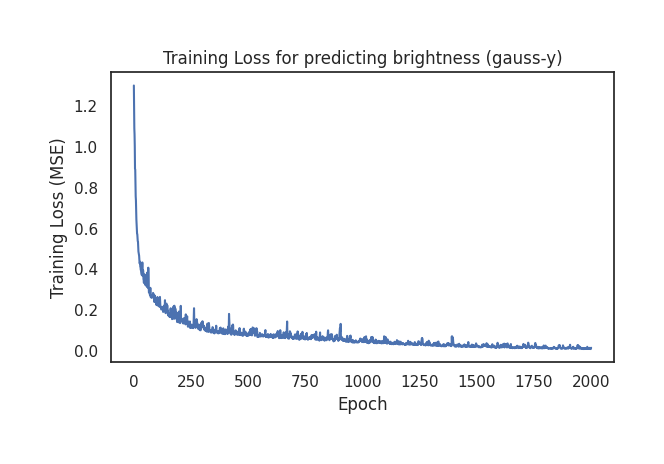

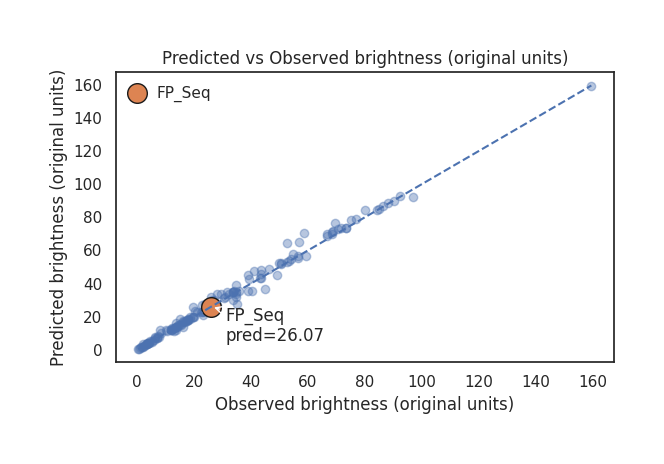

Training complete.


In [9]:
"""
Example script demonstrating how to retrieve fluorescent protein data from the
FPbase REST API and train a simple neural network using PyTorch to predict
various spectral or photophysical properties from the amino-acid sequence.
"""

import os
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import QuantileTransformer

#@markdown ---
#@markdown ## Property selection
#@markdown **Accepted values for `PROPERTY_NAME`:**
#@markdown
#@markdown - **Spectral**
#@markdown   - `ex_max` — excitation maximum *(nm)*
#@markdown   - `em_max` — emission maximum *(nm)*
#@markdown   - `stokes_shift` — excitation/emission separation *(nm)*
#@markdown - **Photophysics**
#@markdown   - `brightness` — FPbase brightness
#@markdown   - `pka` — chromophore pKa
#@markdown ---

PROPERTY_NAME = "brightness"  #@param {type:"string"}

Fluorescent_Protein_Seq = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"  #@param {type:"string"}

#@markdown ---
#@markdown **Frequently used Taxonomy IDs**
#@markdown - `6100`  *(Aequoria victoria)*
#@markdown - `86600` *(Discosoma sp)*
#@markdown - `6118`  *(Entacmaea quadricolor)*
#@markdown
#@markdown - **Leave Blank to Train on Full FPbase.org Sequence Data**
#@markdown ---
PARENT_ORGANISM = 6100  #@param {type:"integer"}

#@markdown ---
#@markdown **Epochs** *(recommended: 5000 for Spectral Properties)*
#@markdown ---
EPOCHS = 2000  #@param {type:"integer"}

#@markdown **Mini-batch size** *(recommended: 16–64; 0 = full batch)*
BATCH_SIZE = 32  #@param {type:"integer"}

LR = 1e-3

#@markdown ---
EXCLUDE_TERMS = ("channelrhodopsin", "rcamp", "gcamp2", "cp-mkate", "cegfp")
AMINO_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Target transform controls
# ----------------------------
# If True: train on Gaussianized y (QuantileTransformer -> normal)
USE_GAUSSIAN_Y = True     # <-- toggle this
GAUSS_N_QUANTILES = 200   # sensible for small datasets; will be capped at n_samples

# -----------------------------------------------------------------------------
# Cleanup helpers

def remove_valine_pos2(seq: str) -> str:
    if not seq or len(seq) < 2:
        return seq
    return (seq[0] + seq[2:]) if (seq[1] == "V") else seq

# -----------------------------------------------------------------------------
# FPbase retrieval + preprocessing

def fetch_fpbase_proteins(parent_organism) -> list:
    proteins: list = []
    parent_organism = "" if parent_organism is None else str(parent_organism).strip()
    if parent_organism.lower() in ("", "none", "null"):
        parent_organism = ""

    if parent_organism:
        if not parent_organism.isdigit():
            raise ValueError(f"PARENT_ORGANISM must be numeric or blank. Got: {parent_organism!r}")
        url = f"https://www.fpbase.org/api/proteins/?parent_organism={parent_organism}&format=json"
    else:
        print("TRAINING ON FULL FPBASE.ORG SEQUENCE DATA")
        url = "https://www.fpbase.org/api/proteins/?&format=json"

    while url:
        print(f"Fetching {url} …")
        resp = requests.get(url, timeout=60)
        resp.raise_for_status()
        data = resp.json()

        if isinstance(data, list):
            proteins.extend(data)
            break

        results = data.get("results", [])
        proteins.extend(results)
        url = data.get("next")

    return proteins


def compute_stokes_shift(protein: dict) -> float | None:
    protein["stokes_shift"] = None
    for state in protein.get("states", []) or []:
        ex = state.get("ex_max")
        em = state.get("em_max")
        if ex is not None and em is not None:
            try:
                shift = float(em) - float(ex)
            except Exception:
                shift = None
            state["stokes_shift"] = shift
            protein["stokes_shift"] = shift
            return shift
    return None


def extract_property(protein: dict, property_name: str) -> float | None:
    if property_name == "stokes_shift":
        if protein.get("stokes_shift") is not None:
            return protein.get("stokes_shift")
        return compute_stokes_shift(protein)

    states = protein.get("states", [])
    if states and isinstance(states, list):
        return states[0].get(property_name)
    return None


def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str = AMINO_ALPHABET) -> np.ndarray:
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    encoding = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            encoding[i, idx] = 1.0
    return encoding

# -----------------------------------------------------------------------------
# Model

class PropertyPredictor(nn.Module):
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

# -----------------------------------------------------------------------------
# Model bundle save/load (for reuse in later cells)

def save_model_bundle(path: str, model: nn.Module, *, max_len: int, amino_alphabet: str,
                      property_name: str, parent_organism, hidden_dim: int = 64,
                      y_transformer=None, used_gaussian_y: bool = False) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    bundle = {
        "state_dict": model.state_dict(),
        "max_len": int(max_len),
        "amino_alphabet": str(amino_alphabet),
        "property_name": str(property_name),
        "parent_organism": parent_organism,
        "hidden_dim": int(hidden_dim),
        "used_gaussian_y": bool(used_gaussian_y),
        # store transformer params so you can reconstruct it later
        "y_transformer": y_transformer,
    }
    torch.save(bundle, path)

# -----------------------------------------------------------------------------
# Run: fetch -> preprocess -> train -> save -> plots

print(f"Predicting property: {PROPERTY_NAME}")
print(f"Device: {DEVICE}")

MODEL_DIR = "models"
MODEL_PATH = os.path.join(
    MODEL_DIR,
    f"fp_{PROPERTY_NAME}_parent{PARENT_ORGANISM if (PARENT_ORGANISM not in [None, '']) else 'ALL'}.pt"
)

# Fetch
proteins = fetch_fpbase_proteins(parent_organism=PARENT_ORGANISM)

# Filter + clean + compute stokes shift + remove V2
cleaned = []
for p in proteins:
    name = (p.get("name") or "").lower()
    if any(term in name for term in EXCLUDE_TERMS):
        continue

    seq = p.get("seq")
    if not seq or len(seq) < 2:
        continue

    seq = remove_valine_pos2(seq)
    p["seq"] = seq

    compute_stokes_shift(p)
    cleaned.append(p)

proteins = cleaned
print(f"Proteins after cleanup: {len(proteins)}")
assert all(p["seq"][1] != "V" for p in proteins if len(p["seq"]) > 1)
print("No Valine remains at position 2")

Fluorescent_Protein_Seq = remove_valine_pos2(Fluorescent_Protein_Seq)

# Build samples
samples: list[tuple[str, float]] = []
for protein in proteins:
    seq = protein.get("seq")
    value = extract_property(protein, PROPERTY_NAME)
    if seq and value is not None:
        try:
            samples.append((seq, float(value)))
        except Exception:
            pass

if not samples:
    raise RuntimeError(f"No valid samples retrieved for property '{PROPERTY_NAME}'.")

max_len = max(len(seq) for seq, _ in samples)
print(f"Usable samples: {len(samples)}")
print(f"Max sequence length in dataset: {max_len}")

X = np.stack([one_hot_encode_sequence(seq, max_len, AMINO_ALPHABET) for seq, _ in samples])
y = np.array([val for _, val in samples], dtype=np.float32)

# -------------------------------------------------------------------------
# NEW: Plot raw distribution + gaussianized distribution
# -------------------------------------------------------------------------
sns.set_theme(style="white", context="notebook")

y_clean = y[np.isfinite(y)]
plt.figure(figsize=(6, 4))
sns.histplot(y_clean, bins=30, kde=True)
plt.title(f"Raw distribution: {PROPERTY_NAME} (n={len(y_clean)})")
plt.xlabel(PROPERTY_NAME)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Gaussianize y (QuantileTransformer -> normal)
nq = int(min(GAUSS_N_QUANTILES, max(10, len(y_clean))))
qt = QuantileTransformer(n_quantiles=nq, output_distribution="normal", random_state=0)

# fit_transform expects 2D
y_gauss = qt.fit_transform(y.reshape(-1, 1)).astype(np.float32).reshape(-1)

plt.figure(figsize=(6, 4))
sns.histplot(y_gauss[np.isfinite(y_gauss)], bins=30, kde=True)
plt.title(f"Gaussian distribution: {PROPERTY_NAME} (QuantileTransformer, n_quantiles={nq})")
plt.xlabel(f"{PROPERTY_NAME} (gaussian)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(f"Target transform: {'GAUSSIANIZED' if USE_GAUSSIAN_Y else 'RAW'}")
print(f"Raw y:    mean={float(np.mean(y_clean)):.3f}  std={float(np.std(y_clean)):.3f}")
print(f"Gauss y:  mean={float(np.mean(y_gauss)):.3f}  std={float(np.std(y_gauss)):.3f}")

# Choose which y to train on
y_train = y_gauss if USE_GAUSSIAN_Y else y
# -------------------------------------------------------------------------

X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)

HIDDEN_DIM = 64
model = PropertyPredictor(input_len=max_len, alphabet_size=len(AMINO_ALPHABET), hidden_dim=HIDDEN_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=float(LR))

use_minibatch = (BATCH_SIZE is not None) and (int(BATCH_SIZE) > 0)
if use_minibatch:
    bs = int(BATCH_SIZE)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=False)
    print(f"Using minibatches: batch_size={bs} | steps/epoch={len(loader)}")
else:
    loader = None
    print("Using full-batch training.")

loss_history = []
pbar = trange(int(EPOCHS), desc="Training", unit="epoch", leave=True, colour="cyan", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [ETA {remaining}] {postfix}")

for epoch in pbar:
    model.train()

    if use_minibatch:
        running_loss = 0.0
        n_samples = 0

        for xb, yb in loader:
            optimizer.zero_grad(set_to_none=True)
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            bsz = xb.size(0)
            running_loss += loss.item() * bsz
            n_samples += bsz

        epoch_loss = running_loss / max(1, n_samples)
        loss_history.append(epoch_loss)
        pbar.set_postfix(loss=f"{epoch_loss:.4f}")

    else:
        optimizer.zero_grad(set_to_none=True)
        preds = model(X_tensor)
        loss = criterion(preds, y_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.4f}")

# Save bundle (stores transformer so you can invert later if you want)
save_model_bundle(
    MODEL_PATH,
    model,
    max_len=max_len,
    amino_alphabet=AMINO_ALPHABET,
    property_name=PROPERTY_NAME,
    parent_organism=PARENT_ORGANISM,
    hidden_dim=HIDDEN_DIM,
    y_transformer=qt if USE_GAUSSIAN_Y else None,
    used_gaussian_y=USE_GAUSSIAN_Y,
)

# In-sample predictions (in training space)
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).squeeze().detach().cpu().numpy()

# Predict user-provided FP sequence (in training space)
fp_enc = one_hot_encode_sequence(Fluorescent_Protein_Seq, max_len, AMINO_ALPHABET)
fp_tensor = torch.tensor(fp_enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    fp_pred = float(model(fp_tensor).squeeze().item())

# If gaussianized training, invert predictions back to original units for interpretability
if USE_GAUSSIAN_Y:
    # inverse_transform expects 2D
    fp_pred_orig = float(qt.inverse_transform(np.array([[fp_pred]], dtype=np.float32))[0, 0])
    preds_orig = qt.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
    print(f"FP_Seq predicted {PROPERTY_NAME} (gaussian): {fp_pred:.3f}")
    print(f"FP_Seq predicted {PROPERTY_NAME} (original): {fp_pred_orig:.3f}")
else:
    fp_pred_orig = fp_pred
    preds_orig = predictions
    print(f"FP_Seq predicted {PROPERTY_NAME}: {fp_pred:.3f}")

# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(range(1, int(EPOCHS) + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title(f"Training Loss for predicting {PROPERTY_NAME} ({'gauss-y' if USE_GAUSSIAN_Y else 'raw-y'})")
plt.tight_layout()
plt.show()

# Plot predicted vs observed (in ORIGINAL units for readability)
plt.figure(figsize=(6,4))
plt.scatter(y, preds_orig, alpha=0.4)

min_val = float(min(y.min(), preds_orig.min(), fp_pred_orig))
max_val = float(max(y.max(), preds_orig.max(), fp_pred_orig))
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.scatter([fp_pred_orig], [fp_pred_orig], s=200, marker="o", edgecolors="k", label="FP_Seq")
plt.annotate(
    f"FP_Seq\npred={fp_pred_orig:.2f}",
    xy=(fp_pred_orig, fp_pred_orig),
    xytext=(10, -25),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
)

plt.xlabel(f"Observed {PROPERTY_NAME} (original units)")
plt.ylabel(f"Predicted {PROPERTY_NAME} (original units)")
plt.title(f"Predicted vs Observed {PROPERTY_NAME} (original units)")
plt.legend()
plt.tight_layout()
plt.show()

# Expose trained objects
TRAINED_MODEL = model
TRAINED_MAX_LEN = max_len
TRAINED_ALPHABET = AMINO_ALPHABET
TRAINED_PROPERTY = PROPERTY_NAME
TRAINED_MODEL_PATH = MODEL_PATH
Y_TRANSFORMER = qt if USE_GAUSSIAN_Y else None
USED_GAUSSIAN_Y = USE_GAUSSIAN_Y

print("Training complete.")


Using in-memory trained model.
Target space: GAUSSIANIZED (QuantileTransformer->normal)

Template predicted brightness: 26.074255 (orig) | 0.086577 (gauss)


Total mutants evaluated: 4522


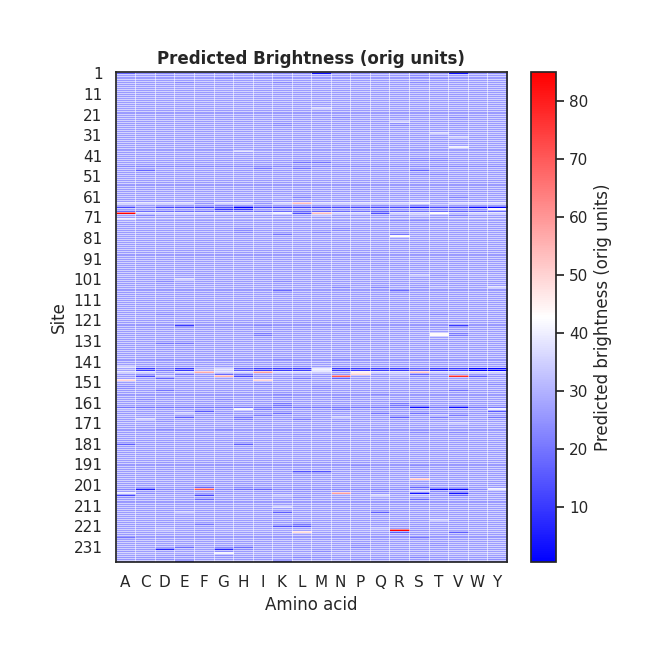

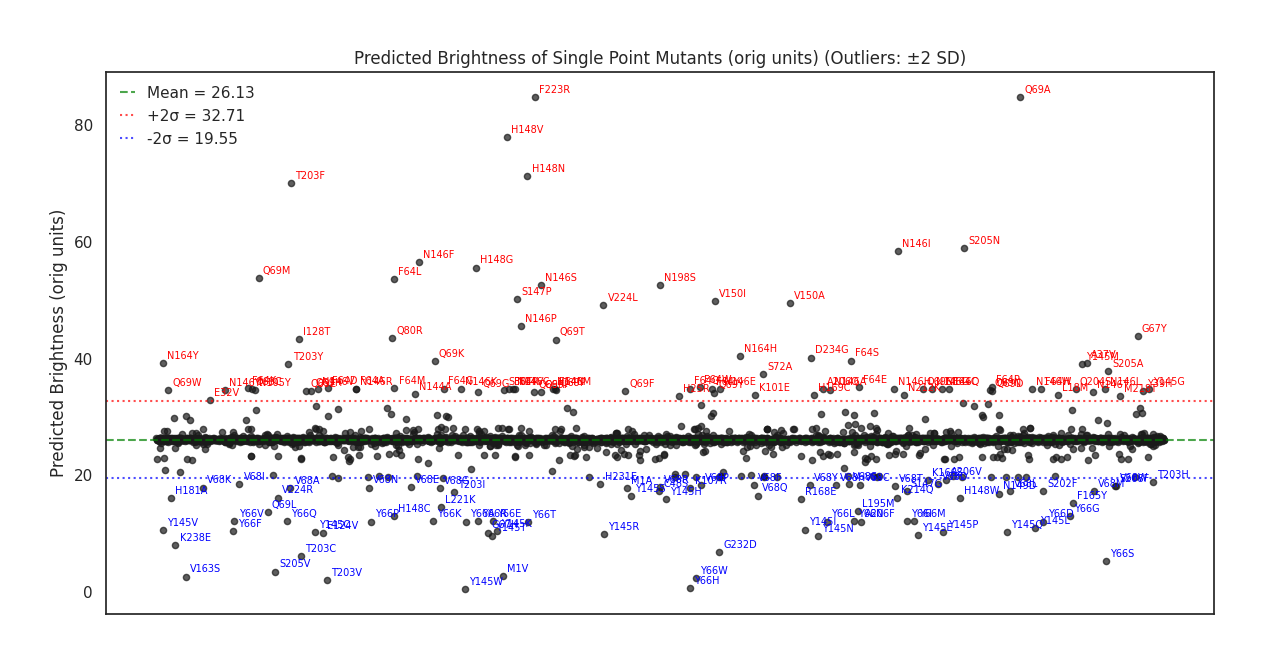

In [10]:
"""
Greedy single-site mutation scan WITHOUT retraining:
- Uses in-memory trained model if available; otherwise loads from a saved bundle
- If model was trained on Gaussianized y (QuantileTransformer->normal), this cell:
    (1) detects it
    (2) inverse-transforms predictions back to original units for plotting + deltas
    (3) still optionally keeps gaussian-space values for debugging

Outputs:
- Heatmap (AA on X, site on Y) in ORIGINAL units (if transformer available)
- Jitter scatter in ORIGINAL units (if transformer available)
- out_df includes both gaussian-space + original-space predictions when applicable
"""

#@markdown ---
#@markdown # Run Global Amino Acid Search Here
#@markdown ---

import os
import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# User inputs for this cell
# ----------------------------
TEMPLATE_SEQ = Fluorescent_Protein_Seq
MODEL_PATH = globals().get("TRAINED_MODEL_PATH", "models/fp_stokes_shift_parent6100.pt")
DEFAULT_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"

N_STD = 2
JITTER = 0.20

HEATMAP_FIGSIZE = (6, 6)
HEATMAP_FACE = "w"
HEATMAP_CMAP = "bwr"

# ----------------------------
# Model + encoding definitions
# ----------------------------
def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str) -> np.ndarray:
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    arr = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            arr[i, idx] = 1.0
    return arr

class PropertyPredictor(nn.Module):
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

def load_model_bundle(path: str, device: str = "cpu"):
    bundle = torch.load(path, map_location=device)

    max_len = int(bundle["max_len"])
    alphabet = str(bundle.get("amino_alphabet", DEFAULT_ALPHABET))
    property_name = str(bundle.get("property_name", "property"))
    hidden_dim = int(bundle.get("hidden_dim", 64))

    used_gaussian_y = bool(bundle.get("used_gaussian_y", False))
    y_transformer = bundle.get("y_transformer", None)  # may be None depending on how it was saved

    model = PropertyPredictor(input_len=max_len, alphabet_size=len(alphabet), hidden_dim=hidden_dim).to(device)
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model, max_len, alphabet, property_name, used_gaussian_y, y_transformer

# ----------------------------
# Acquire model WITHOUT training
# ----------------------------
if "TRAINED_MODEL" in globals() and "TRAINED_MAX_LEN" in globals() and "TRAINED_ALPHABET" in globals():
    model = globals()["TRAINED_MODEL"].to(DEVICE)
    max_len = int(globals()["TRAINED_MAX_LEN"])
    alphabet = str(globals()["TRAINED_ALPHABET"])
    property_name = str(globals().get("TRAINED_PROPERTY", "property"))
    model.eval()
    print("Using in-memory trained model.")

    USED_GAUSSIAN_Y = bool(globals().get("USED_GAUSSIAN_Y", False))
    Y_TRANSFORMER = globals().get("Y_TRANSFORMER", None)
else:
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(
            f"MODEL_PATH not found: {MODEL_PATH}\n"
            "Run your training cell first (to create the bundle), or set MODEL_PATH to an existing .pt bundle."
        )
    model, max_len, alphabet, property_name, USED_GAUSSIAN_Y, Y_TRANSFORMER = load_model_bundle(MODEL_PATH, device=DEVICE)
    print(f"Loaded model bundle from: {MODEL_PATH}")

print(f"Target space: {'GAUSSIANIZED (QuantileTransformer->normal)' if USED_GAUSSIAN_Y else 'RAW'}")
if USED_GAUSSIAN_Y and (Y_TRANSFORMER is None):
    print("WARNING: Model says gaussianized-y, but no Y_TRANSFORMER is available to invert. "
          "Plots will remain in gaussian units.")

def to_orig(v: float) -> float:
    """Convert model output -> original units if transformer exists; else pass-through."""
    if (not USED_GAUSSIAN_Y) or (Y_TRANSFORMER is None):
        return float(v)
    return float(Y_TRANSFORMER.inverse_transform(np.array([[v]], dtype=np.float32))[0, 0])

# ----------------------------
# Baseline prediction
# ----------------------------
template_enc = one_hot_encode_sequence(TEMPLATE_SEQ, max_len, alphabet)
template_tensor = torch.tensor(template_enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    baseline_pred_gauss = float(model(template_tensor).squeeze().item())
baseline_pred = to_orig(baseline_pred_gauss)

if USED_GAUSSIAN_Y and Y_TRANSFORMER is not None:
    print(f"\nTemplate predicted {property_name}: {baseline_pred:.6f} (orig) | {baseline_pred_gauss:.6f} (gauss)\n")
else:
    print(f"\nTemplate predicted {property_name}: {baseline_pred:.6f}\n")

# ----------------------------
# Greedy single-site scan
# ----------------------------
mutant_predictions = {}        # label -> predicted (ORIG units if possible)
mutant_predictions_gauss = {}  # label -> predicted (GAUSS units)
mutant_deltas = {}             # label -> delta vs baseline (same units as mutant_predictions)

for pos0, orig_aa in enumerate(TEMPLATE_SEQ):
    site = pos0 + 1
    for new_aa in alphabet:
        if new_aa == orig_aa:
            continue

        mutated_seq = TEMPLATE_SEQ[:pos0] + new_aa + TEMPLATE_SEQ[pos0+1:]
        enc = one_hot_encode_sequence(mutated_seq, max_len, alphabet)
        x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred_gauss = float(model(x).squeeze().item())
        pred = to_orig(pred_gauss)

        label = f"{orig_aa}{site}{new_aa}"
        delta = pred - baseline_pred

        mutant_predictions[label] = pred
        mutant_predictions_gauss[label] = pred_gauss
        mutant_deltas[label] = delta

print(f"\nTotal mutants evaluated: {len(mutant_predictions)}")

# ----------------------------
# Build matrix for heatmap (ORIG units if possible)
# ----------------------------
pattern = re.compile(r"^([A-Z])(\d+)([A-Z])$")
records = []
site_set = set()

for k, v in mutant_predictions.items():
    m = pattern.match(k)
    if not m:
        continue
    _, pos_s, newaa = m.groups()
    pos = int(pos_s)
    records.append((pos, newaa, float(v)))
    site_set.add(pos)

aa_order = list(alphabet)
site_order = sorted(site_set)

df = pd.DataFrame(index=site_order, columns=aa_order, dtype=float)
for pos, newaa, val in records:
    if (pos in df.index) and (newaa in df.columns):
        df.loc[pos, newaa] = val

# Fill NaNs (identity AAs we skipped) with per-row min for display
filled = df.copy()
if filled.isna().any().any():
    row_mins = filled.min(axis=1)
    for r in filled.index:
        filled.loc[r] = filled.loc[r].fillna(row_mins[r])

# ----------------------------
# HEATMAP
# ----------------------------
plt.figure(figsize=HEATMAP_FIGSIZE, facecolor=HEATMAP_FACE)
ax = plt.gca()
ax.set_facecolor(HEATMAP_FACE)

im = ax.imshow(
    filled.values,
    aspect="auto",
    cmap=HEATMAP_CMAP,
    interpolation="nearest",
    origin="upper"
)

ax.set_xticks(np.arange(len(aa_order)))
ax.set_xticklabels(aa_order)

ytick_step = 10
ytick_idx = np.arange(0, len(site_order), ytick_step)
ax.set_yticks(ytick_idx)
ax.set_yticklabels([site_order[i] for i in ytick_idx])

ax.set_xticks(np.arange(-0.5, len(aa_order), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(site_order), 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

units_note = " (orig units)" if (not USED_GAUSSIAN_Y or Y_TRANSFORMER is not None) else " (gauss units)"
ax.set_xlabel("Amino acid")
ax.set_ylabel("Site")
ax.set_title(f"Predicted {property_name.title()}{units_note}", fontweight="bold")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f"Predicted {property_name}{units_note}")

plt.tight_layout()
plt.show()

# ----------------------------
# JITTER SCATTER (ORIG units if possible)
# ----------------------------
sorted_items = sorted(mutant_predictions.items(), key=lambda x: x[1], reverse=True)
mut_labels = [k for k, _ in sorted_items]
pred_vals = np.array([v for _, v in sorted_items], dtype=float)
delta_vals = np.array([mutant_deltas[k] for k in mut_labels], dtype=float)

mean_val = float(pred_vals.mean())
std_val = float(pred_vals.std(ddof=0))
upper = mean_val + N_STD * std_val
lower = mean_val - N_STD * std_val

x_jitter = np.random.uniform(-JITTER, JITTER, size=len(pred_vals))

plt.figure(figsize=(12, 6), facecolor="w")
ax = plt.gca()
ax.set_facecolor("w")

plt.scatter(x_jitter, pred_vals, s=20, alpha=0.7, color="k")

for xi, yi, label in zip(x_jitter, pred_vals, mut_labels):
    if yi > upper or yi < lower:
        plt.annotate(
            label, (xi, yi),
            textcoords="offset points", xytext=(3, 3),
            ha="left", fontsize=7,
            color="red" if yi > upper else "blue",
        )

plt.axhline(mean_val, linestyle="--", alpha=0.7, label=f"Mean = {mean_val:.2f}", color="green")
plt.axhline(upper, linestyle=":", alpha=0.7, label=f"+{N_STD}σ = {upper:.2f}", color="red")
plt.axhline(lower, linestyle=":", alpha=0.7, label=f"-{N_STD}σ = {lower:.2f}", color="blue")
plt.legend()

plt.ylabel(f"Predicted {property_name.title()}{units_note}")
plt.title(f"Predicted {property_name.title()} of Single Point Mutants{units_note} (Outliers: ±{N_STD} SD)")
plt.grid(False)
plt.xticks([])
plt.tight_layout()
plt.show()

# ----------------------------
# Export table (includes BOTH spaces if applicable)
# ----------------------------
out_df = pd.DataFrame({
    "mutation": mut_labels,
    "predicted": pred_vals,                     # orig units if possible, else gauss
    "delta_vs_template": delta_vals,            # matches "predicted" units
    "predicted_gauss": [mutant_predictions_gauss[k] for k in mut_labels],  # always model space
    "baseline_gauss": baseline_pred_gauss,
    "baseline_orig": baseline_pred,
    "used_gaussian_y": USED_GAUSSIAN_Y,
    "has_transformer": (Y_TRANSFORMER is not None),
}).sort_values("predicted", ascending=False)

csv_name = f"all_single_mutants_{property_name}.csv"
# out_df.to_csv(csv_name, index=False)
# print(f"\nWrote full table (all mutations) to: {csv_name}")


<hr>

<h1 align="right" style="font-size:48px;">PyTorch-Based Design</h1>

<p align="left">
  <img src="https://raw.githubusercontent.com/CameronLarsonFLT/PyTorch_FP_Prediction/main/FP_Design.png" width="550">
</p>

<p align="right">
<ul>
  <li>PyTorch regressor predicts protein properties directly from amino-acid sequence</li>
  <li>Greedy / Top-K search explores single-site mutations from a template</li>
  <li>Mutations ranked by predicted improvement and applied iteratively</li>
  <li>Supports deterministic or stochastic optimization paths</li>
  <li>Outputs optimized variants as FASTA for analysis</li>
</ul>
</p>

<hr>


In [11]:
"""
Greedy search to design N sequences WITHOUT retraining.

Uses ONLY vars already defined in your training cell:
- PROPERTY_NAME, AMINO_ALPHABET, DEVICE
- TRAINED_MODEL / TRAINED_MAX_LEN / TRAINED_ALPHABET / TRAINED_PROPERTY / TRAINED_MODEL_PATH
- USED_GAUSSIAN_Y, Y_TRANSFORMER (if gaussianized training was enabled)
- Fluorescent_Protein_Seq (template)

Writes ONE multi-FASTA file to OUT_DIR (template first, then designs).

This version is TOP-K ONLY (always samples from top-K at each step).
If the model was trained on gaussianized y, this will:
- gate + rank in gaussian space (consistent with training)
- print + write headers in BOTH gaussian and original units (via inverse_transform)
"""

#@markdown ---
#@markdown # Run Greedy Amino Acid Search with Top-K Sampling (Gaussian Transformed)
#@markdown ---

import os
import numpy as np
import torch
import torch.nn as nn
import datetime

#@markdown ---
#@markdown ## Objective
#@markdown - MAXIMIZE=True for properties like brightness, stokes_shift, em_max
#@markdown - MAXIMIZE=False for properties you want to minimize
#@markdown ---
MAXIMIZE = True  #@param {type:"boolean"}

#@markdown ---
#@markdown ## Greedy step threshold
#@markdown IMPORTANT:
#@markdown - If your model was trained with gaussianized y, STEP_THRESHOLD is in *gaussian space* (z-like units).
#@markdown - If trained on raw y, STEP_THRESHOLD is in original units (nm, pKa, brightness, etc.)
#@markdown Typical gaussian thresholds: 0.05–0.30
#@markdown ---
STEP_THRESHOLD = 0.15  #@param {type:"number"}

#@markdown ---
#@markdown ## Design controls
#@markdown - N_DESIGNS = how many designed sequences to generate
#@markdown - MAX_MUTATIONS = max mutations per design
#@markdown ---
N_DESIGNS = 10      #@param {type:"integer"}
MAX_MUTATIONS = 10  #@param {type:"integer"}

#@markdown ---
#@markdown ## Top-K sampling (ALWAYS ON)
#@markdown At each step, we:
#@markdown 1) score all single-AA mutations that pass threshold
#@markdown 2) sort by predicted property
#@markdown 3) randomly pick ONE from the top-K
#@markdown ---
TOPK_PER_STEP = 3  #@param {type:"integer"}

#@markdown ---
#@markdown ## Optional constraint
#@markdown If True, don't mutate the same position twice within a design.
#@markdown ---
AVOID_REPEAT_POS = False  #@param {type:"boolean"}

#@markdown ---
#@markdown ## Output
#@markdown ---
OUT_DIR = "designed_seqs_greedy"     #@param {type:"string"}
WRITE_FASTA = True                  #@param {type:"boolean"}
MULTIFASTA_BASENAME = "ALL_DESIGNS"  #@param {type:"string"}

# ----------------------------
# Model helpers (must match training architecture)
# ----------------------------
def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str) -> np.ndarray:
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    arr = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            arr[i, idx] = 1.0
    return arr

class PropertyPredictor(nn.Module):
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

def load_model_bundle(path: str, device: str = "cpu"):
    bundle = torch.load(path, map_location=device)
    max_len = int(bundle["max_len"])
    alphabet = str(bundle.get("amino_alphabet", AMINO_ALPHABET))
    prop = str(bundle.get("property_name", PROPERTY_NAME))
    hidden_dim = int(bundle.get("hidden_dim", 64))
    used_gaussian_y = bool(bundle.get("used_gaussian_y", False))
    y_transformer = bundle.get("y_transformer", None)

    model = PropertyPredictor(input_len=max_len, alphabet_size=len(alphabet), hidden_dim=hidden_dim).to(device)
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model, max_len, alphabet, prop, used_gaussian_y, y_transformer

def predict_seq_gauss(model: nn.Module, seq: str, max_len: int, alphabet: str, device: str) -> float:
    """Always returns prediction in the model's native training space (gauss if trained that way)."""
    enc = one_hot_encode_sequence(seq, max_len, alphabet)
    x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        return float(model(x).squeeze().item())

def gauss_to_orig(y_gauss: float, qt):
    """Inverse-transform a single gaussian-space prediction into original units (if qt available)."""
    if qt is None:
        return None
    try:
        return float(qt.inverse_transform(np.array([[y_gauss]], dtype=np.float32))[0, 0])
    except Exception:
        return None

def muts_to_labels(original_seq: str, mutated_seq: str) -> list[str]:
    labels = []
    for i, (a, b) in enumerate(zip(original_seq, mutated_seq)):
        if a != b:
            labels.append(f"{a}{i+1}{b}")
    return labels

def wrap_fasta(seq: str, width: int = 60) -> str:
    return "\n".join(seq[i:i+width] for i in range(0, len(seq), width))

# ----------------------------
# Acquire trained model + gaussian flags (NO retraining)
# ----------------------------
bundle_used_gauss = None
bundle_qt = None

if "TRAINED_MODEL" in globals() and "TRAINED_MAX_LEN" in globals() and "TRAINED_ALPHABET" in globals():
    model = TRAINED_MODEL.to(DEVICE)
    max_len = int(TRAINED_MAX_LEN)
    trained_alphabet = str(TRAINED_ALPHABET)
    trained_prop = str(globals().get("TRAINED_PROPERTY", PROPERTY_NAME))
    model.eval()
    print("Using in-memory trained model.")

    # Prefer explicit globals from your gaussian-training cell if present
    bundle_used_gauss = bool(globals().get("USED_GAUSSIAN_Y", False))
    bundle_qt = globals().get("Y_TRANSFORMER", None)

else:
    if not ("TRAINED_MODEL_PATH" in globals()):
        raise RuntimeError("TRAINED_MODEL_PATH not found. Run the training cell first.")
    if not os.path.exists(TRAINED_MODEL_PATH):
        raise FileNotFoundError(f"Model bundle not found: {TRAINED_MODEL_PATH}")

    model, max_len, trained_alphabet, trained_prop, bundle_used_gauss, bundle_qt = load_model_bundle(
        TRAINED_MODEL_PATH, device=DEVICE
    )
    print(f"Loaded model bundle from: {TRAINED_MODEL_PATH}")

# Sanity printout
print(f"Device: {DEVICE}")
print(f"Property: {trained_prop} | MAXIMIZE={MAXIMIZE}")
print(f"Gaussian-y trained: {bool(bundle_used_gauss)}")
print(f"Template length: {len(Fluorescent_Protein_Seq)} | max_len: {max_len}")
print(f"Alphabet size used this run: {len(trained_alphabet)}")

alphabet = trained_alphabet
template = Fluorescent_Protein_Seq
scan_positions = list(range(len(template)))

if bool(WRITE_FASTA):
    os.makedirs(OUT_DIR, exist_ok=True)

# Baseline in gaussian/native space
baseline_pred_g = predict_seq_gauss(model, template, max_len, alphabet, DEVICE)

# Also show original-units baseline if possible
baseline_pred_orig = gauss_to_orig(baseline_pred_g, bundle_qt) if bundle_used_gauss else baseline_pred_g

if bundle_used_gauss:
    print(f"\nTemplate predicted {trained_prop}: gauss={baseline_pred_g:.6f} | orig={baseline_pred_orig:.6f}\n")
else:
    print(f"\nTemplate predicted {trained_prop}: {baseline_pred_g:.6f}\n")

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
multifasta_path = None
if bool(WRITE_FASTA):
    multifasta_path = os.path.join(OUT_DIR, f"{MULTIFASTA_BASENAME}_{trained_prop}_{timestamp}.fasta")

# ----------------------------
# Top-K greedy design loop (single design)
# ----------------------------
def topk_design() -> tuple[str, float]:
    current = template
    current_pred_g = baseline_pred_g
    used_positions = set()

    for _step in range(1, int(MAX_MUTATIONS) + 1):
        candidates = []  # (trial_pred_g, delta_g, pos0, newaa)

        for pos0 in scan_positions:
            if bool(AVOID_REPEAT_POS) and (pos0 in used_positions):
                continue
            orig = current[pos0]
            for newaa in alphabet:
                if newaa == orig:
                    continue

                trial = current[:pos0] + newaa + current[pos0+1:]
                trial_pred_g = predict_seq_gauss(model, trial, max_len, alphabet, DEVICE)
                delta_g = trial_pred_g - current_pred_g

                if bool(MAXIMIZE):
                    if delta_g >= float(STEP_THRESHOLD):
                        candidates.append((trial_pred_g, delta_g, pos0, newaa))
                else:
                    if delta_g <= -float(STEP_THRESHOLD):
                        candidates.append((trial_pred_g, delta_g, pos0, newaa))

        if not candidates:
            break

        # Sort by objective in gaussian/native space (consistent with training)
        if bool(MAXIMIZE):
            candidates.sort(key=lambda x: x[0], reverse=True)
        else:
            candidates.sort(key=lambda x: x[0])

        # Sample ONE from top-K
        k = max(1, min(int(TOPK_PER_STEP), len(candidates)))
        chosen = candidates[np.random.randint(0, k)]

        new_pred_g, _delta_g, pos0, newaa = chosen
        current = current[:pos0] + newaa + current[pos0+1:]
        current_pred_g = new_pred_g
        used_positions.add(pos0)

    return current, current_pred_g

# ----------------------------
# Generate N designs + write multifasta
# ----------------------------
fh_multi = None
if bool(WRITE_FASTA):
    fh_multi = open(multifasta_path, "w", encoding="utf-8")

    # Include design params in template header
    params_tag = f"maxmut={int(MAX_MUTATIONS)}|topk={int(TOPK_PER_STEP)}|thr={float(STEP_THRESHOLD):.4g}|avoidrep={int(bool(AVOID_REPEAT_POS))}"
    if bundle_used_gauss:
        fh_multi.write(f">TEMPLATE_{trained_prop}|gauss=1|{params_tag}|pred_g={baseline_pred_g:.6f}|pred_orig={baseline_pred_orig:.6f}\n")
    else:
        fh_multi.write(f">TEMPLATE_{trained_prop}|gauss=0|{params_tag}|pred={baseline_pred_g:.6f}\n")

    fh_multi.write(wrap_fasta(template) + "\n")

try:
    for i in range(1, int(N_DESIGNS) + 1):
        seq, pred_g = topk_design()
        labels = muts_to_labels(template, seq)

        # Convert to original units for reporting (if gaussian-trained)
        pred_orig = gauss_to_orig(pred_g, bundle_qt) if bundle_used_gauss else pred_g
        delta_g = pred_g - baseline_pred_g
        delta_orig = (pred_orig - baseline_pred_orig) if (pred_orig is not None and baseline_pred_orig is not None) else None

        design_name = f"Design_{i:03d}_{trained_prop}"
        params_tag = f"maxmut={int(MAX_MUTATIONS)}|topk={int(TOPK_PER_STEP)}|thr={float(STEP_THRESHOLD):.4g}|avoidrep={int(bool(AVOID_REPEAT_POS))}"

        if bundle_used_gauss:
            header = (
                f">{design_name}|gauss=1|{params_tag}"
                f"|pred_g={pred_g:.6f}|delta_g={delta_g:+.6f}"
                f"|pred_orig={pred_orig:.6f}|delta_orig={delta_orig:+.6f}"
                f"|nmut={len(labels)}"
            )
        else:
            header = (
                f">{design_name}|gauss=0|{params_tag}"
                f"|pred={pred_g:.6f}|delta={delta_g:+.6f}"
                f"|nmut={len(labels)}"
            )

        print(header)
        print(f"Mutations: {', '.join(labels) if labels else '(none)'}")
        print(wrap_fasta(seq))
        print()

        if bool(WRITE_FASTA) and fh_multi is not None:
            fh_multi.write(header + "\n")
            fh_multi.write(wrap_fasta(seq) + "\n")

finally:
    if fh_multi is not None:
        fh_multi.close()

if bool(WRITE_FASTA):
    print(f"\nMulti-FASTA written to:\n  {multifasta_path}")

# ----------------------------
# Quick reminder about STEP_THRESHOLD units
# ----------------------------
if bundle_used_gauss:
    print("\nNOTE: Model is gaussian-y trained, so STEP_THRESHOLD is in gaussian space.")
    print("      If you want to think in original units, use smaller thresholds (e.g., 0.05–0.30) and rely on pred_orig/delta_orig for interpretation.")


Using in-memory trained model.
Device: cuda
Property: brightness | MAXIMIZE=True
Gaussian-y trained: True
Template length: 238 | max_len: 353
Alphabet size used this run: 20

Template predicted brightness: gauss=0.086577 | orig=26.074255

>Design_001_brightness|gauss=1|maxmut=10|topk=3|thr=0.15|avoidrep=0|pred_g=13.077873|delta_g=+12.991296|pred_orig=159.539993|delta_orig=+133.465738|nmut=10
Mutations: F64L, Q69A, S72A, Q80R, N146F, H148V, N198S, T203F, S205N, F223R
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTL
VTTLSYGVACFARYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLV
NRIELKGIDFKEDGNILGHKLEYNYFSVNVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD
HYQQNTPIGDGPVLLPDSHYLSFQNALSKDPNEKRDHMVLLERVTAAGITHGMDELYK

>Design_002_brightness|gauss=1|maxmut=10|topk=3|thr=0.15|avoidrep=0|pred_g=13.040078|delta_g=+12.953501|pred_orig=159.539993|delta_orig=+133.465738|nmut=10
Mutations: Q69A, Q80R, N146F, S147P, H148V, N198S, T203F, S205N, F223R, V224L
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGK

In [12]:
#@markdown ---
#@markdown # Download Dependencies to Generate MSA
#@markdown ---


RUN_INSTALL = True
if RUN_INSTALL:
    print("Downloading dependencies...\n")

    from tqdm.auto import tqdm
    import subprocess

    steps = [
        ["apt-get", "-qq", "update"],
        ["apt-get", "-qq", "install", "-y", "mafft"],
        ["pip", "-q", "install", "pymsaviz"],
        ["pip", "-q", "install", "biopython"],
    ]

    with tqdm(
        total=len(steps),
        desc="",
        bar_format="{bar} {n_fmt}/{total_fmt}",
        colour="cyan",
    ) as pbar:
        for cmd in steps:
            subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
            pbar.update(1)


           0/4

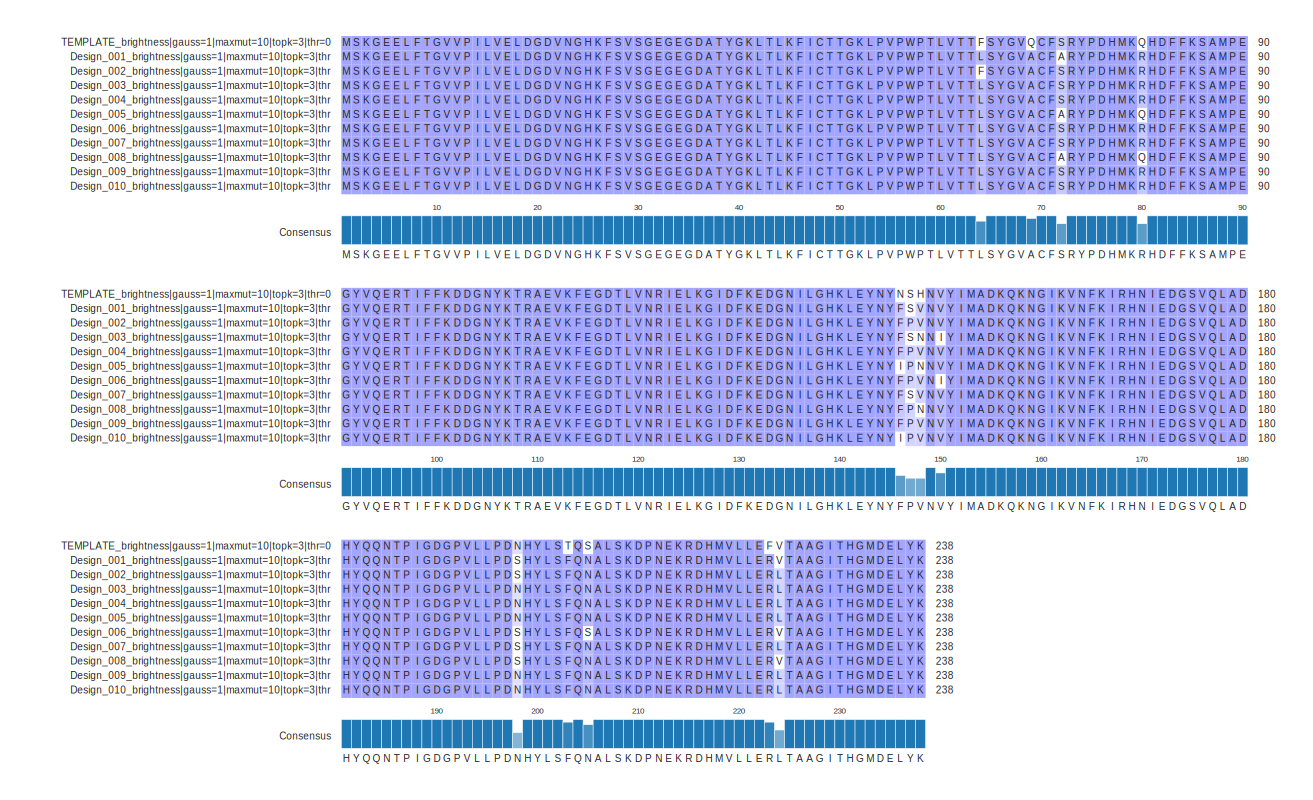

In [13]:
#@markdown ---
#@markdown # Run MAFFT MSA on the multi-FASTA
#@markdown ---

import os
import subprocess
from datetime import datetime
import tempfile
from collections import Counter

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

try:
    from pymsaviz import MsaViz
except ImportError:
    MsaViz = None

from IPython.display import SVG, display


#@markdown ---
#@markdown ## Inputs / Outputs
#@markdown ---
INPUT_FASTA = multifasta_path  #@param {type:"string"}
OUTDIR = "msa_outputs"         #@param {type:"string"}

#@markdown ---
#@markdown ## Visualization
#@markdown ---
WRAP_LENGTH = 90               #@param {type:"integer"}
CONSENSUS_THRESHOLD = 0.501    #@param {type:"number"}
MAKE_SVG = True                #@param {type:"boolean"}

# Always do U->X; do NOT use --anysymbol
REPLACE_U_WITH_X = True
USE_ANY_SYMBOL = False


def consensus_from_alignment(msa, threshold=0.501, gap_char="-"):
    L = msa.get_alignment_length()
    out = []
    for col in range(L):
        syms = [rec.seq[col] for rec in msa]
        non_gaps = [c for c in syms if c != gap_char]
        if not non_gaps:
            out.append(gap_char)
            continue
        counts = Counter(non_gaps)
        top, n = counts.most_common(1)[0]
        out.append(top if (n / len(non_gaps)) >= threshold else "X")
    return "".join(out)


def run_basic_msa(input_fasta_path: str, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    with tempfile.TemporaryDirectory() as tmpdir:
        cleaned_fasta = os.path.join(tmpdir, "cleaned.fasta")
        aligned_fasta = os.path.join(tmpdir, "aligned.fasta")

        # Clean FASTA (U->X, strip non-AA)
        cleaned = []
        allowed = set("ACDEFGHIKLMNPQRSTVWYXBZJO-")  # exclude U because we replace it

        for rec in SeqIO.parse(input_fasta_path, "fasta"):
            seq = str(rec.seq).upper()
            if REPLACE_U_WITH_X:
                seq = seq.replace("U", "X")
            seq = "".join(c for c in seq if c in allowed)
            if seq:
                cleaned.append(SeqRecord(Seq(seq), id=rec.id[:50], description=""))

        SeqIO.write(cleaned, cleaned_fasta, "fasta")

        # MAFFT
        mafft = ["mafft", "--auto", cleaned_fasta]
        proc = subprocess.run(mafft, capture_output=True, text=True)
        if proc.returncode != 0:
            raise RuntimeError(proc.stderr or "MAFFT failed (no stderr)")

        with open(aligned_fasta, "w", encoding="utf-8") as f:
            f.write(proc.stdout)

        alignment = AlignIO.read(aligned_fasta, "fasta")
        consensus = consensus_from_alignment(alignment, float(CONSENSUS_THRESHOLD))

        aln_out = os.path.join(output_dir, f"aligned_{timestamp}.fasta")
        con_out = os.path.join(output_dir, f"consensus_{timestamp}.txt")
        AlignIO.write(alignment, aln_out, "fasta")
        with open(con_out, "w", encoding="utf-8") as f:
            f.write(consensus + "\n")

        if MAKE_SVG and MsaViz is not None:
            svg_path = os.path.join(output_dir, f"msa_{timestamp}.svg")
            viz = MsaViz(
                aln_out,
                wrap_length=int(WRAP_LENGTH),
                show_label=True,
                show_count=True,
                show_consensus=True,
                color_scheme="Identity",
            )
            viz.savefig(svg_path)
            display(SVG(filename=svg_path))


# Run
run_basic_msa(INPUT_FASTA, OUTDIR)
